# DEPENDÊNCIAS


In [441]:
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,make_scorer, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('ignore')

# DECLARAÇÕES DE FUNÇÕES


### Função para Calcular e comparar a curva roc dos modelos encontrados

In [445]:
def compare_roc_curves(models, model_names, x_test, y_test):
    # Obtendo probabilidades da classe positiva
    plt.figure(figsize=(8,6))

    for model, name in zip(models, model_names):
        # Obtendo probabilidades da classe positiva
        y_scores = model.best_estimator_.predict_proba(x_test)[:, 1]

        # Calculando a curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plotando a curva ROC
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    # Adicionando linha de referência (classificador aleatório)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Configurando o gráfico
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Comparação das Curvas ROC')
    plt.legend(loc='lower right')
    plt.show()

### Função para tratamento de valores nulos ( simulação de regra de negócio ) 

In [448]:
def fillna_with_mean_or_median(column, data):
    min_val = data[column].min()
    max_val = data[column].max()
    mean = data[column].mean()
    median = data[column].median()

    intervalo = max_val - min_val
    result = data[column]
    if intervalo > 2 * mean: 
        data[column] = result.fillna(median)
    else:
        data[column] = result.fillna(mean)

### Função para avaliar a quantidade de pontos que cada modelo fez ( simulação de regra de negócio ) 

In [451]:
def evaluate_model(yreal, ypred):
    # Calcula a matriz de confusão
    conf_matrix = confusion_matrix(yreal, ypred)

    # Extrai pontuações da matriz
    TP = conf_matrix[1, 1]  # Verdadeiros positivos - Era de boa qualidade e ele previu corretamente [+30]
    FP = conf_matrix[0, 1]  # Falsos positivos - Era de baixa qualidade e ele previu como boa [ -10 pontos ]
    TN = conf_matrix[0, 0]  # Verdadeiros negativos - era de baixa qualidade e ele previu como baixa [ +30 ]
    FN = conf_matrix[1, 0]  # Falsos negativos - Era de alta qualidade e ele previu como baixa [-60]

    # Calcular regra de avaliação
    return ((-60 * FN) + (-10 * FP) + (30 * TP) + (30 * TN)) 

### Função para calcular e plotar as importancias das Features

In [454]:
def show_importance_features(model:GridSearchCV):
        # Extração do melhor modelo dentro do Pipeline
    best_pipeline = model.best_estimator_
    best_model = best_pipeline.named_steps['model']  # Acessa o modelo dentro do pipeline

    # Pegando o pré-processador do pipeline
    preprocessor = best_pipeline.named_steps['transformer']

    # Pegar nomes das colunas transformadas e remover prefixos
    try:
        feature_names = preprocessor.get_feature_names_out()
        feature_names = [name.split("__")[-1] for name in feature_names]  # Remove "num_continuas__"
    except AttributeError:
        feature_names = [f"feature_{i}" for i in range(x_train.shape[1])]  # Nomes genéricos

    # Verificar o tipo do modelo corretamente
    if isinstance(best_model, (LogisticRegression, SVC)):
        if hasattr(best_model, "coef_"):  # Apenas modelos lineares (SVC com kernel="linear")
            coef = best_model.coef_.flatten()  # Achata os coeficientes

            # Verifica se o número de coeficientes corresponde ao número de atributos
            if len(coef) == len(feature_names):
                imp = pd.DataFrame({"atributos": feature_names, "importancia": coef})
                imp = imp.sort_values(by="importancia", ascending=True)

                # Construindo gráfico
                plt.figure(figsize=(10, 6))
                plt.barh(y=imp['atributos'], width=imp['importancia'])
                plt.xlabel("Importância")
                plt.ylabel("Atributos")
                plt.title(f"Importância dos Atributos - {best_model.__class__.__name__}")
                plt.show()
            else:
                print(f"Erro: O número de coeficientes ({len(coef)}) não bate com o número de atributos ({len(feature_names)})")
        else:
            print(f"O modelo {best_model.__class__.__name__} usa um kernel que não fornece coeficientes.")

    elif isinstance(best_model, DecisionTreeClassifier):
        imp = pd.DataFrame({"atributos": feature_names, "importancia": best_model.feature_importances_})
        imp = imp.sort_values(by="importancia", ascending=True)

        # Construindo gráfico
        plt.figure(figsize=(10, 6))
        plt.barh(y=imp['atributos'], width=imp['importancia'])
        plt.xlabel("Importância")
        plt.ylabel("Atributos")
        plt.title(f"Importância dos Atributos - {best_model.__class__.__name__}")
        plt.show()

    else:
        print(f"O modelo {best_model.__class__.__name__} não fornece coeficientes de importância.")

### Função para Calcular os resultados do modelo e exibir todas as médias por K - Fold

In [457]:
# Função para exibir os resultados do modelo
# Esta função tem como objetivo verificar se o modelo está generalizando bem
# Ela avalia cada iteração do Kfolds e calcula a média para cada K e soma no final;
# Ao final, conseguimos ver se o modelo está generalizando bem as informações se os marcadores médios do K forem próximos aos marcadores da base de teste completa
def show_results_models(model: GridSearchCV, x_train, x_test, y_train, y_test, exec_train=True):
    print('Best params ==>', model.best_params_)
    print('Best score:', model.best_score_)

    if exec_train:
        yhat_predicted_train = model.best_estimator_.predict(x_train)
        print('Desempenho - Base de Treino')
        print(classification_report(y_train, yhat_predicted_train))

    yhat_predicted_test = model.best_estimator_.predict(x_test)
    print('Desempenho - Base de Teste')
    print(classification_report(y_test, yhat_predicted_test))

    # Extração dos resultados do GridSearchCV
    results = model.cv_results_

    # Número de folds usados no K-Fold
    n_splits = len([key for key in results.keys() if key.startswith("split")]) // 4

    # Criar listas com métricas de cada fold
    accuracy = [results[f"split{i}_test_accuracy"][model.best_index_] for i in range(n_splits)]
    precision = [results[f"split{i}_test_precision"][model.best_index_] for i in range(n_splits)]
    recall = [results[f"split{i}_test_recall"][model.best_index_] for i in range(n_splits)]
    f1_scores = [results[f"split{i}_test_f1"][model.best_index_] for i in range(n_splits)]  # <- Nome corrigido

    # Criar listas para armazenar os valores acumulados
    acc_means, acc_stds = [], []
    prec_means, prec_stds = [], []
    recall_means, recall_stds = [], []
    f1_means, f1_stds = [], []

    for i in range(1, n_splits + 1):
        acc_means.append(np.mean(accuracy[:i]))
        acc_stds.append(np.std(accuracy[:i]))
        prec_means.append(np.mean(precision[:i]))
        prec_stds.append(np.std(precision[:i]))
        recall_means.append(np.mean(recall[:i]))
        recall_stds.append(np.std(recall[:i]))
        f1_means.append(np.mean(f1_scores[:i]))  # <- Nome corrigido
        f1_stds.append(np.std(f1_scores[:i]))  # <- Nome corrigido

    # Criar DataFrame com as métricas de cada iteração acumulada
    metrics_df = pd.DataFrame({
        "Fold": range(1, n_splits + 1),
        "Accuracy Mean": acc_means,
        "Accuracy Std": acc_stds,
        "Precision Mean": prec_means,
        "Precision Std": prec_stds,
        "Recall Mean": recall_means,
        "Recall Std": recall_stds,
        "F1-score Mean": f1_means,
        "F1-score Std": f1_stds
    })

    # Exibir a tabela formatada por Fold
    print("\n========== Tabela de métricas por iteração do K-Fold ==========")
    print(metrics_df.to_string(index=False))

    # Cálculo final da média e do desvio padrão das métricas
    mean_values = {
        "Accuracy": np.mean(accuracy),
        "Precision": np.mean(precision),
        "Recall": np.mean(recall),
        "F1-score": np.mean(f1_scores)  # <- Nome corrigido
    }

    std_values = {
        "Accuracy": np.std(accuracy),
        "Precision": np.std(precision),
        "Recall": np.std(recall),
        "F1-score": np.std(f1_scores)  # <- Nome corrigido
    }

    # Criar DataFrame para exibir a estatística final
    summary_df = pd.DataFrame([mean_values, std_values], index=["Média", "Desvio Padrão"])
 
    print("\n========== Comparação direta das métricas no conjunto de teste ==========")
    print("Accuracy:", accuracy_score(y_test, yhat_predicted_test))
    print("Precision (macro):", precision_score(y_test, yhat_predicted_test, average="macro"))
    print("Recall (macro):", recall_score(y_test, yhat_predicted_test, average="macro"))
    print("F1-score (macro):", f1_score(y_test, yhat_predicted_test, average="macro"))
    
    print("Precision (weighted):", precision_score(y_test, yhat_predicted_test, average="weighted"))
    print("Recall (weighted):", recall_score(y_test, yhat_predicted_test, average="weighted"))
    print("F1-score (weighted):", f1_score(y_test, yhat_predicted_test, average="weighted"))
    
    # Exibir estatísticas finais
    print("\n========== Estatísticas finais das métricas ==========")
    print(summary_df.to_string(index=True))

    print("\n============== Avaliação do negócio (TESTE) ==============")
    print('Total de pontos do modelo ==> ' + str(evaluate_model(y_test, yhat_predicted_test))) 

    show_importance_features(model)

# ITEM 1

### IMPORTAÇÃO DOS DADOS


In [460]:
# importando CSV dos dados
PATH = 'C:/Users/Bruno Adalberto/Desktop/Aulas Pós/Primeiro Módulo/Trabalho Final/winequalityN.csv'
data = pd.read_csv(PATH)
data.columns = data.columns.str.lower().str.replace(' ', '_')

display(data.head()) 

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Verificando informações dos dados 

In [463]:
print(data['type'].value_counts())
data.info()
data.isna().sum()


type
white    4898
red      1599
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   ph                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
ph                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

# ITEM 2  

#### Transformação da Variável "quality"  

A base de dados possui uma variável denominada **`quality`**, que representa a qualidade do vinho em uma escala de **0 a 10**. Para simplificar a análise, será criada uma nova variável categórica chamada **`opinion`**, seguindo as regras:  

- **`opinion = 0`** → Quando `quality` for **menor ou igual a 5**.  
- **`opinion = 1`** → Quando `quality` for **maior que 5**.  

Após essa transformação, a variável **`quality`** será descartada do restante da análise.  

**Obs:** Inicialmente, utilizaremos **apenas os vinhos do tipo "Branco"** para a análise.  

---

### **Pré-processamento dos Dados**  

No código a seguir, realizamos algumas etapas fundamentais para a preparação dos dados:  

1. Criamos a coluna **`opinion`** para a classificação binária dos vinhos.  
2. Tratamos valores nulos, aplicando uma regra de negócio que ajusta os valores ausentes para **a média ou a mediana**.  
3. Removemos **linhas duplicadas**, preservando **apenas a última ocorrência** de cada registro.  


In [466]:
#Adiciona coluna binária opinion
data['opinion'] = np.where(data['quality'] <= 5, 1, 0)
data.drop(columns=['quality'], inplace=True) 

In [468]:

#tratar os dados nulos.
#Abordagem, vou verificar o valor minimo e máximo da coluna para verificar se há muita variação dos valores, 
# se não houver, usarei a media, se não, usarei a mediana para tratar os nulos. 
fillna_with_mean_or_median('fixed_acidity', data)  
fillna_with_mean_or_median('volatile_acidity', data)  
fillna_with_mean_or_median('citric_acid', data)  
fillna_with_mean_or_median('residual_sugar', data)  
fillna_with_mean_or_median('chlorides', data)  
fillna_with_mean_or_median('ph', data)
fillna_with_mean_or_median('sulphates', data)

#verificar informações duplicadas removendo as duplicadas preserando a última linha
num_duplicatas = data.duplicated().sum()
 

data.isna().sum()
data_red = data.query("type == 'red'")
data = data.query("type == 'white'") 
 

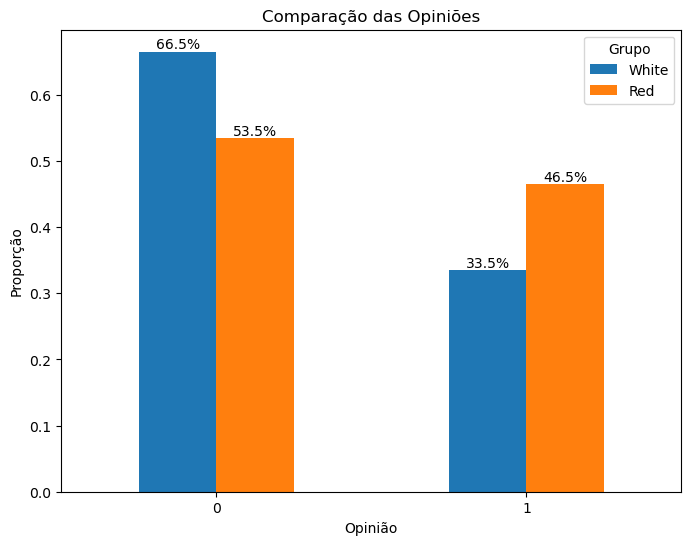

In [470]:
# Calculando as proporções
proportions_full = data['opinion'].value_counts(normalize=True)
proportions_red = data_red['opinion'].value_counts(normalize=True)

# Criando um DataFrame para facilitar a comparação
df = pd.DataFrame({
    'White': proportions_full,
    'Red': proportions_red
}).fillna(0)  # Preencher valores ausentes com 0

# Criando o gráfico de barras agrupadas
ax = df.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Opinião') 
plt.ylabel('Proporção')
plt.title('Comparação das Opiniões')
plt.xticks(rotation=0)
plt.legend(title='Grupo')

# Adicionando porcentagens acima de cada barra
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Evitar exibir valores em barras vazias
        ax.annotate(f'{height:.1%}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.show()

# ITEM 3

### Descrição das Variáveis  

A seguir, são descritas as variáveis presentes na base de dados, incluindo seus tipos (discreta, categórica, contínua) e suas definições:  

#### **Variáveis Categóricas**  
- **`type`**: Define o tipo do vinho (Tinto ou Branco). *(CATEGÓRICA)*  
- **`opinion`**: Variável alvo (target). *(CATEGÓRICA)*  

#### **Variáveis Contínuas**  
- **`fixed_acidity`**: Acidez fixa – ácidos não voláteis do vinho. *(CONTÍNUA)*  
- **`volatile_acidity`**: Acidez volátil – representa os ácidos que evaporam facilmente. *(CONTÍNUA)*  
- **`citric_acid`**: Ácido cítrico. *(CONTÍNUA)*  
- **`residual_sugar`**: Açúcar residual – açúcares que não foram fermentados pelo fermento. *(CONTÍNUA)*  
- **`chlorides`**: Cloretos – representam o teor de sal no vinho. *(CONTÍNUA)*  
- **`free_sulfur_dioxide`**: Dióxido de enxofre livre – usado como conservante. *(CONTÍNUA)*  
- **`total_sulfur_dioxide`**: Dióxido de enxofre total – indicador importante de qualidade e estabilidade do vinho. *(CONTÍNUA)*  
- **`density`**: Densidade – relacionada ao teor alcoólico e ao açúcar residual. *(CONTÍNUA)*  
- **`ph`**: Mede a acidez geral do vinho. *(CONTÍNUA)*  
- **`sulphates`**: Sulfatos – contribuem para a estabilidade microbiológica e preservação do vinho. *(CONTÍNUA)*  
- **`alcohol`**: Teor alcoólico. *(CONTÍNUA)*  

#### **Variáveis Discretas**  
- **`quality`**: Qualidade do vinho (avaliação numérica). *(DISCRETA)*  


In [473]:
print(data.dtypes)

# Ver estatísticas das variáveis 
data.describe()

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                 float64
opinion                   int32
dtype: object


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,opinion
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.856121,0.278269,0.334241,6.391864,0.045779,35.308085,138.360657,0.994027,3.188246,0.489843,10.514267,0.334831
std,0.843244,0.100740,0.120961,5.071702,0.021845,17.007137,42.498065,0.002991,0.150910,0.114124,1.230621,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


# ITEM 4 (A)  

### Etapas para Criar um Modelo de Classificação Eficiente  

1. **Leitura dos dados**  
2. **Avaliação dos tipos de dados**, identificando variáveis categóricas, discretas e contínuas.  
3. **Verificação dos dados nulos** e definição da melhor abordagem para tratá-los, de acordo com as necessidades do negócio.  
4. **Eliminar a coluna de teste** e definir a variável **target**.  
5. **Verificar o balanceamento das classes**.  
6. **Análise de separabilidade linear** (visual) usando **Pairplot**.  
7. **Separar as variáveis em `X` e `Y`**, onde:  
   - `X` → Variáveis utilizadas para os cálculos do modelo.  
   - `Y` → Variável **target**.  
8. **Aplicar o `stratify`** para manter a proporção das classes ao separar os dados de treino e teste.  
9. **Separação Treino/Teste** usando **`train_test_split`** com **`stratify`**.  
10. **Análise das proporções dos dados** para verificar se foram mantidas em relação ao dataset original.  
11. **Criar um modelo baseline**, escolhendo a abordagem mais adequada ao problema.  
12. **Avaliar as métricas do modelo baseline**.  
13. **Treinar o modelo escolhido** (ou testar múltiplos modelos).  
14. **Configurar o amostrador** para as validações cruzadas.  
15. **Ajustar os hiperparâmetros** do modelo.  
16. **Utilizar `GridSearch`** para encontrar as melhores combinações de hiperparâmetros.  
17. **Analisar as métricas do melhor modelo**, avaliando:  
    - **Matriz de confusão**  
    - **Curva ROC**  
    - **Indicadores relevantes para o negócio**, como **Precision, Recall, F1-Score e Accuracy**.  


In [476]:
# Definindo variáveis numéricas e categóricas 
data.head()
num = [col for col in data.columns if col not in ['type', 'opinion']] 
target = 'opinion'

x = data.drop(columns=[target])
y = data[[target]]

x_red = data_red.drop(columns=[target])
y_red = data_red[[target]]
 

### Analisando a separabilidade Linear das informações em 2D

#### Por que utilizar PCA para Análise de Separabilidade Linear?

Quando temos um conjunto de dados com múltiplas variáveis, visualizar a separação entre classes pode ser um tanto complicado. O **PCA (Principal Component Analysis)** é uma técnica que permite reduzir a dimensionalidade do dataset, mantendo a maior quantidade de informação possível.  

#### Benefícios do PCA na análise de separabilidade  

- **Redução de Dimensionalidade** → Condensa múltiplas variáveis em apenas dois eixos (`PCA1` e `PCA2`), permitindo visualização em 2D sem perder padrões importantes.  
- **Identificação de Padrões** → Facilita a visualização da separação entre as classes `"opinion"`, destacando se há uma fronteira linear entre `Baixa Qualidade (0)` e `Alta Qualidade (1)`.  
- **Pré-processamento para Modelos** → Caso os dados apresentem sobreposição, podemos avaliar a necessidade de técnicas não lineares para classificação.  

#### Como interpretar o gráfico de PCA?  
Se as classes `"opinion"` estiverem **bem separadas no gráfico**, indica que uma **fronteira linear pode ser eficiente** para classificá-las. Caso contrário, pode ser necessário um modelo mais robusto para a separação.  

Com isso, conseguimos entender melhor a distribuição dos dados e tomar decisões mais assertivas na modelagem.


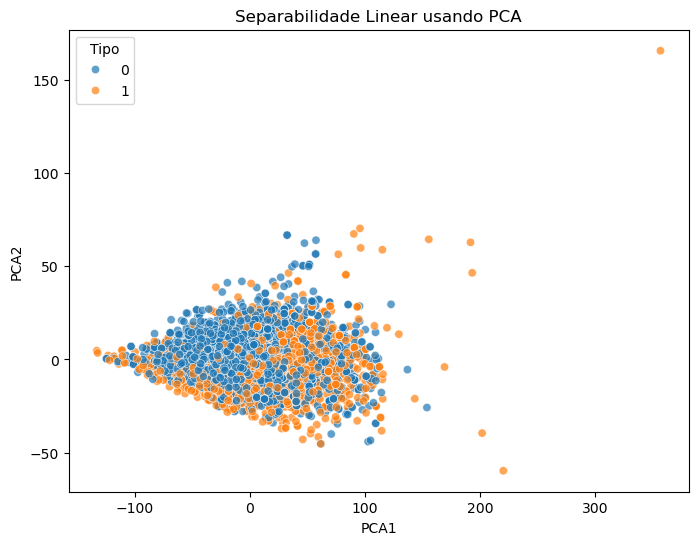

In [535]:
# Seleciona apenas variáveis numéricas
features = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
            "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
            "ph", "sulphates", "alcohol"]

X = data[features]

# Aplicar PCA para reduzir para 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Criar um DataFrame com os componentes principais
data_pca = data.copy()
data_pca["PCA1"] = X_pca[:, 0]
data_pca["PCA2"] = X_pca[:, 1]

# Scatter plot com os novos eixos do PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_pca, x="PCA1", y="PCA2", hue="opinion", alpha=0.7)

plt.title("Separabilidade Linear usando PCA")
plt.legend(title="Tipo")
plt.show()

### Separação dos dados em treino e teste mantendo a proporção das classes (`Stratify`) e preservando 30% dos dados para teste  


In [482]:

# separação treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=2)

print(y_train.value_counts(normalize=True))

opinion
0          0.665111
1          0.334889
Name: proportion, dtype: float64


### Criando um modelo baseline para comparação  


In [485]:
#Criando um modelo baseline
y_base = np.repeat(0, repeats=y_test.shape[0])

# métricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       978
           1       0.00      0.00      0.00       492

    accuracy                           0.67      1470
   macro avg       0.33      0.50      0.40      1470
weighted avg       0.44      0.67      0.53      1470



### Criando Pipeline de processamento e dos modelos


In [488]:
# criando um pipeline de processamento 
preprocessor = ColumnTransformer([ # Aplicando o Ohe para a categoria type
    ('num_continuas', RobustScaler(), num), # aplicando a escala robusta para as demais variaveis  
])

# criando os pipelines
reglog = Pipeline([
    ('transformer', preprocessor),
    ('model', LogisticRegression(solver='saga'))
])

dt_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', DecisionTreeClassifier(random_state=2))
])

svm_pipeline = Pipeline([
    ('transformer', preprocessor),  # Reutilizando o mesmo pré-processador
    ('model', SVC(probability=True, random_state=2))  # Ativar probabilidade para avaliação de performance
])

# configurar o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

<h1>ITEM 4 (B) </h1>

<h3><p>Treine um modelo de regressão logística usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:</p></h3>

<h3><p style="color:blue;">Item de rúbrica:</p> Qual a diferença entre Regressão Linear e Regressão Logistica?</h3>

<p><h5>A principal diferença entre Regressão Linear e a Logística é o tipo de problema que elas resolvem.</p>
<p></p>A Regressão Linear é utilizada para prever valores contínuos devido a sua formúla que ajusta uma linha reta para prever valores com base nas variáveis de entrada</p>  
<p>A Regressão Logistica é utilizada para Classificação Binária ( 0, 1 ) Ela usa uma função Sigmoide ( uma linha em formato de S ) para converter uma predição contínua em probabilidade</p></h5>   

### Regressão Linear
A equação da regressão linear é:

$$
\begin{aligned}
Y = b_0 + b_1X_1 + b_2X_2 + ... + b_nX_n
\end{aligned}
$$

Onde:  
- \( Y \) é a variável alvo (previsão do modelo),  
- \( X_1, X_2, ..., X_n \) são as variáveis independentes,  
- \( b_0, b_1, ..., b_n \) são os coeficientes do modelo.
</br>
</br>
### Regressão Logística
A equação da regressão logística é:

$$
\begin{aligned}
P(Y=1) = \frac{1}{1 + e^{-(b_0 + b_1X_1 + b_2X_2 + ... + b_nX_n)}}
\end{aligned}
$$

Onde:  
- \( P(Y=1) \) representa a **probabilidade da classe positiva** (por exemplo, 1 = doença presente).  
- \( e \) é a base do logaritmo natural (**aproximadamente 2.718**).  
- \( b_0, b_1, ..., b_n \) são os coeficientes do modelo.  

A decisão final é feita considerando um **limiar de 0.5**:
- Se \( P(Y=1) > 0.5 \), **classifica como 1 (positivo)**.  
- Se \( P(Y=1) < 0.5 \), **classifica como 0 (negativo)**.
- 
##  Função Sigmoide (Usada na Regressão Logística)
A **função sigmoide** transforma um valor contínuo em uma **probabilidade**.

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Onde:

$$
z = b_0 + b_1X_1 + b_2X_2 + ... + b_nX_n
$$

---






# Métricas de Avaliação de Modelos

## 1. Acurácia
A **Acurácia** mede a proporção de previsões corretas em relação ao total de previsões feitas.

$$
\begin{aligned}
\text{Acurácia} &= \frac{TP + TN}{TP + TN + FP + FN}
\end{aligned}
$$

Onde:
- **TP** = Verdadeiros Positivos  
- **TN** = Verdadeiros Negativos  
- **FP** = Falsos Positivos  
- **FN** = Falsos Negativos  

---

## 2. Precisão (Precision)
A **Precisão** mede a proporção de previsões positivas que realmente são positivas.

$$
\begin{aligned}
\text{Precisão} &= \frac{TP}{TP + FP}
\end{aligned}
$$

- **Alta precisão** significa poucos **falsos positivos (FP)**.  

---

## 3. Recall (Sensibilidade)
O **Recall** mede a proporção de exemplos positivos corretamente classificados.

$$
\begin{aligned}
\text{Recall} &= \frac{TP}{TP + FN}
\end{aligned}
$$

- **Alto recall** significa poucos **falsos negativos (FN)**.  

---

## 4. F1-Score
O **F1-Score** é a média harmônica entre Precisão e Recall.

$$
\begin{aligned}
F1 &= 2 \times \frac{\text{Precisão} \times \text{Recall}}{\text{Precisão} + \text{Recall}}
\end{aligned}
$$

- O **F1-score** é útil quando há **desequilíbrio entre as classes**.

---



# ITEM 4 (B)

### Treine um modelo de **Regressão Logística** usando um modelo de validação cruzada estratificada com **k-folds (k=10)** para realizar a classificação.  

### Calcule para a base de teste:


In [493]:

#TREINAMENTO DO MODELO DE REGRESSÃO LOGISTICA
params_grid_reglog = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None]
}

scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# configurar o buscador
search_reglog = GridSearchCV(
    estimator=reglog,
    param_grid=params_grid_reglog,
    scoring=scoring_metrics,
    cv=splitter,
    refit="f1",
    error_score=0,
    n_jobs=-1
)

search_reglog.fit(x_train, y_train) 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num_continuas',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcoho...
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

## Resultado  

#### i. A média e desvio da **acurácia** dos modelos obtidos.  
#### ii. A média e desvio da **precisão** dos modelos obtidos.  
#### iii. A média e desvio do **recall** dos modelos obtidos.  
#### iv. A média e desvio do **F1-score** dos modelos obtidos.  


Best params ==> {'model__C': 1, 'model__class_weight': None, 'model__l1_ratio': 0.25, 'model__penalty': 'elasticnet'}
Best score: 0.7432725992491866
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       978
           1       0.67      0.48      0.56       492

    accuracy                           0.75      1470
   macro avg       0.72      0.68      0.69      1470
weighted avg       0.74      0.75      0.73      1470


========== Tabela de métricas por iteração do K-Fold ==========
 Fold  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-score Mean  F1-score Std
    1       0.746356      0.000000        0.737116       0.000000     0.746356    0.000000       0.736577      0.000000
    2       0.746356      0.000000        0.736967       0.000149     0.746356    0.000000       0.735625      0.000952
    3       0.742468      0.005497        0.732630       0.006134     0.

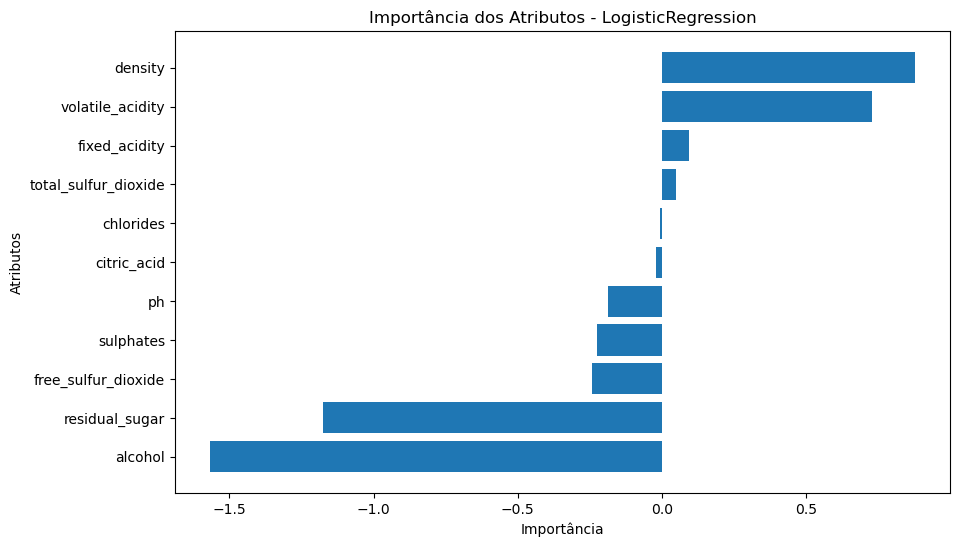

In [495]:
show_results_models(search_reglog, x_train, x_test, y_train, y_test, False)

# ITEM 4 (C)

### Treine um modelo de **Árvores de Decisão** usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação.  
### Calcule para a base de teste:


In [497]:
#TREINAMENTO DO MODELO DE ARVORE DE DECISÃO
params_grid_dt = {
    'model__max_depth': range(2, 5),  
    'model__criterion': ['gini', 'entropy'],  
    'model__class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}, 'balanced', None],  # Aumenta o peso da classe 1
    'model__min_samples_split': [2, 5, 10]  # Experimentando mais valores
}


# configurar o buscador
search_dt_categ = GridSearchCV(
    estimator=dt_categ,
    param_grid=params_grid_dt,
    scoring=scoring_metrics,
    cv=splitter,
    refit="f1",
    error_score=0, 
    n_jobs=-1
)

search_dt_categ.fit(x_train, y_train) 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num_continuas',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcoho...
                         'model__min_samples_split': [2, 5, 10]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

## Resultado  

#### i. A média e desvio da **acurácia** dos modelos obtidos.  
#### ii. A média e desvio da **precisão** dos modelos obtidos.  
#### iii. A média e desvio do **recall** dos modelos obtidos.  
#### iv. A média e desvio do **F1-score** dos modelos obtidos.  


Best params ==> {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_split': 2}
Best score: 0.7301972265796143
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       978
           1       0.65      0.53      0.59       492

    accuracy                           0.75      1470
   macro avg       0.72      0.69      0.70      1470
weighted avg       0.74      0.75      0.74      1470


========== Tabela de métricas por iteração do K-Fold ==========
 Fold  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-score Mean  F1-score Std
    1       0.725948      0.000000        0.713709       0.000000     0.725948    0.000000       0.712787      0.000000
    2       0.734694      0.008746        0.725399       0.011690     0.734694    0.008746       0.725867      0.013080
    3       0.719145      0.023120        0.708858       0.025

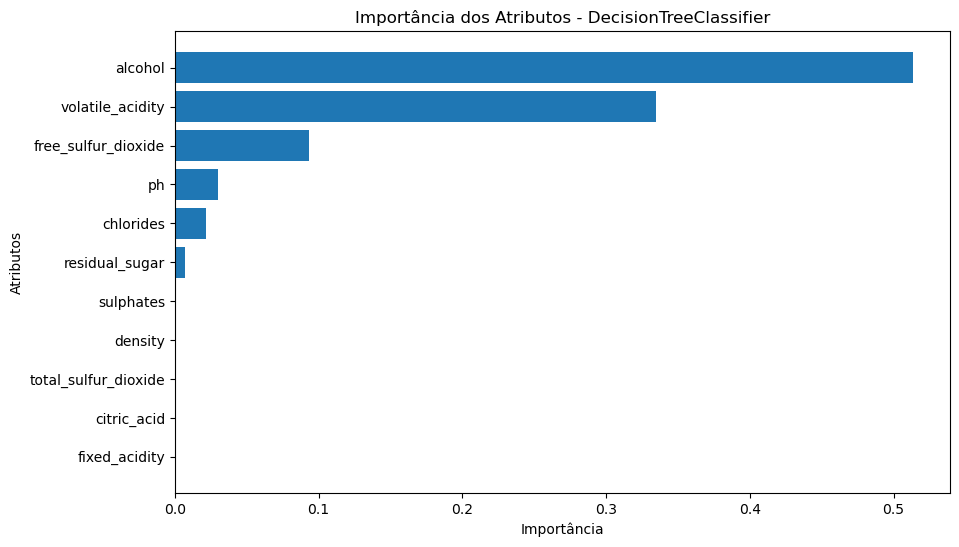

In [499]:
show_results_models(search_dt_categ, x_train, x_test, y_train, y_test, False)

# ITEM 4 (D)

### Treine um modelo de **SVM** usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação.  
### Calcule para a base de teste:

In [501]:
#TREINAMENTO DO MODELO SVM
params_grid_svm = {
    'model__C': [0.1, 1, 10],  
    'model__kernel': ['linear'],  
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],   
}

# Criando o GridSearchCV para otimizar o modelo
search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=params_grid_svm,
    scoring=scoring_metrics,   
    cv=splitter,   
    refit='f1',
    error_score=0,
    n_jobs=-1
)

# Treinando o modelo SVM
search_svm.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num_continuas',
                                                                         RobustScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'residual_sugar',
                                                                          'chlorides',
                                                                          'free_sulfur_dioxide',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'ph',
                                                                          'sulphates',
                                                                          'alcoho...
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'model__kernel': ['linear']},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

## Resultado  

#### i. A média e desvio da **acurácia** dos modelos obtidos.  
#### ii. A média e desvio da **precisão** dos modelos obtidos.  
#### iii. A média e desvio do **recall** dos modelos obtidos.  
#### iv. A média e desvio do **F1-score** dos modelos obtidos.  


Best params ==> {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best score: 0.7415160971210203
Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      2280
           1       0.69      0.49      0.58      1148

    accuracy                           0.76      3428
   macro avg       0.74      0.69      0.70      3428
weighted avg       0.75      0.76      0.74      3428

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       978
           1       0.67      0.46      0.54       492

    accuracy                           0.74      1470
   macro avg       0.72      0.67      0.68      1470
weighted avg       0.73      0.74      0.73      1470


========== Tabela de métricas por iteração do K-Fold ==========
 Fold  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-score Mean  F1-s

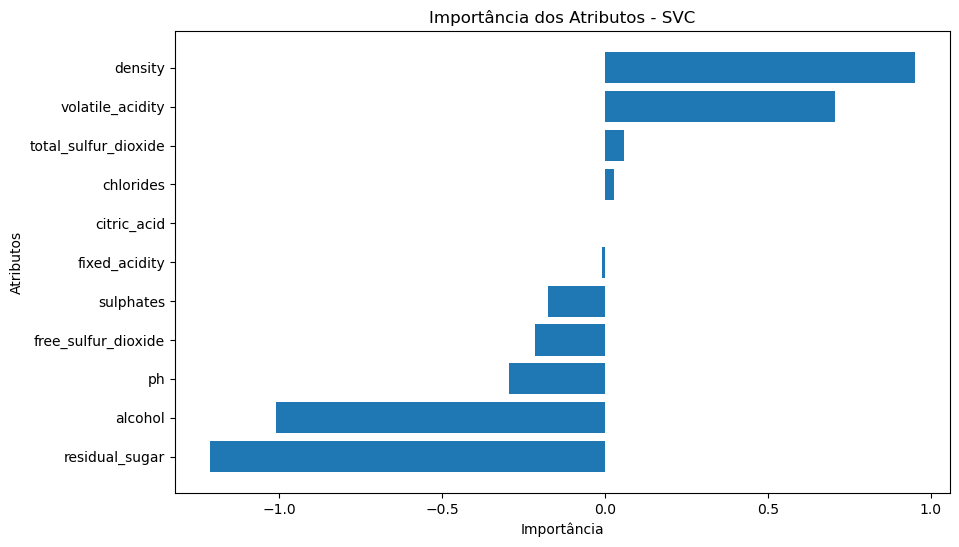

In [503]:
show_results_models(search_svm, x_train, x_test, y_train, y_test)

# Análise da Influência das Features na Qualidade do Vinho  

## Interpretação dos Resultados  
Após a criação dos modelos **Regressão Logística**, **SVM** e **Decision Tree**, analisamos a importância das variáveis e encontramos os seguintes padrões:  

- **Regressão Logística** e **SVM** identificaram **Densidade** e **Acidez Volátil** como as variáveis mais relevantes, com coeficientes próximos de **1**, indicando que valores mais altos dessas features aumentam a chance de um vinho ser classificado como de **boa qualidade**.  
- Essas mesmas técnicas atribuíram coeficientes próximos de **-1** para **Teor Alcoólico** e **Açúcar Residual**, sugerindo que valores elevados dessas variáveis aumentam a probabilidade de um vinho ser classificado como de **baixa qualidade**.  
- Já a **Decision Tree** apresentou uma distribuição de importância das variáveis diferente, atribuindo maior peso a outros fatores, o que sugere que esse modelo pode estar capturando padrões específicos da base de dados de forma distinta.  

## Principais Insights  

### 1. Por que Densidade e Acidez Volátil estão associadas à melhor qualidade?  
- A **densidade** reflete a concentração de compostos dissolvidos no vinho. Em vinhos de alta qualidade, pode estar associada a um equilíbrio adequado entre álcool, taninos e açúcares.  
- A **acidez volátil** está relacionada à presença de ácidos como o acético. Pequenas quantidades podem contribuir para a complexidade aromática, tornando o vinho mais interessante.  

### 2. Por que Teor Alcoólico e Açúcar Residual estão associadas à menor qualidade?  
- O **teor alcoólico**, normalmente um fator positivo, pode estar correlacionado negativamente dependendo da base de dados. Se vinhos de menor qualidade tiverem um teor alcoólico desbalanceado, o modelo pode ter identificado essa relação.  
- O **açúcar residual** pode indicar vinhos mais doces, que nem sempre são bem avaliados dependendo do perfil dos avaliadores e do contexto do dataset. Em vinhos secos, um excesso de açúcar pode sugerir problemas na fermentação.  

## Considerações sobre o Modelo  
- **Diferenças entre os modelos**: A **Regressão Logística** e o **SVM** capturaram padrões similares, destacando as mesmas variáveis como mais influentes. No entanto, a **Decision Tree** apresentou um comportamento diferente, sugerindo que pode estar mais sensível a interações não lineares ou a características específicas do dataset.  
- **Correlação não implica causalidade**: os modelos identificam padrões estatísticos, mas isso não significa que essas variáveis sejam as únicas responsáveis pela qualidade do vinho.  
- **Possível viés no dataset**: se há predominância de vinhos de baixa qualidade com alto teor alcoólico, por exemplo, o modelo pode reforçar essa associação sem que ela seja universalmente válida.  


# ITEM 5

### Em relação à questão anterior, qual modelo deveria ser escolhido para uma eventual operação?

Responda essa questão comparando todos os modelos, utilizando um **gráfico com a curva ROC média** para cada modelo.  

Além disso, **justifique a escolha do melhor modelo** com base nos resultados obtidos.


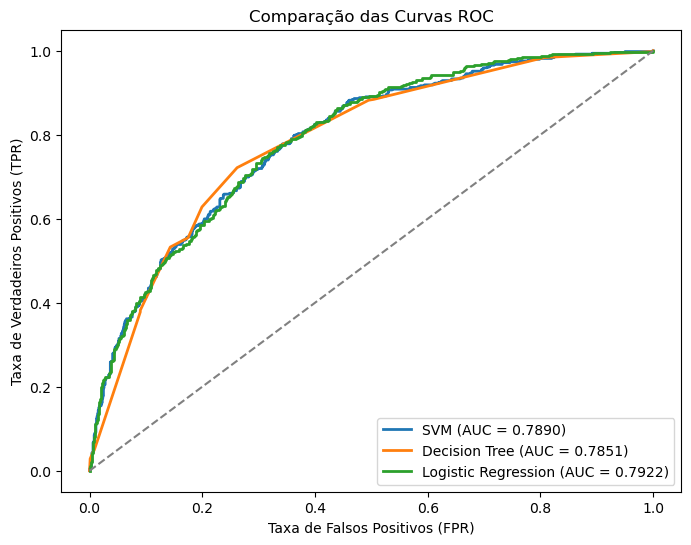

In [506]:
compare_roc_curves(
    models=[search_svm, search_dt_categ, search_reglog],  # GridSearchCV dos modelos
    model_names=['SVM', 'Decision Tree', 'Logistic Regression'],
    x_test=x_test,
    y_test=y_test
)

# Resultado da Análise

## Escolha do Melhor Modelo  

Com base na **Curva ROC, AUC e outras métricas estatísticas**, a **Regressão Logística** foi o modelo escolhido pois apresentou o melhor desempenho global, com um **AUC de 0,7922**. No entanto, isso pode não refletir necessariamente a melhor escolha para o negócio. É fundamental avaliar marcadores específicos para ajustar os modelos de forma a maximizar o lucro ou obter o melhor resultado prático.  

Para ilustrar melhor essa análise, foi criada uma função para calcular um **"prejuízo"** associado a classificações incorretas, considerando os seguintes critérios:  

- **Falso Negativo (0 classificado como 1):** -60.00 pontos  
- **Verdadeiro Positivo (1 classificado corretamente como 1):** +30 pontos  
- **Falso Positivo (1 classificado como 0):** -10 pontos *(não queremos cobrar mais caro por um vinho inferior)*  
- **Verdadeiro Negativo (0 classificado corretamente como 0):** +30 pontos  

### Pontuação Final por Modelo  

| Modelo                | Pontuação Final | AUC (Curva ROC) |
|-----------------------|---------------:|---------------:|
| **Regressão Logística** | **16.250**  | **0,7922** |
| **Árvore de Decisão**  | **17.800**  | **0,7851** |
| **SVM**               | **15.620**  | **0,7890** |

A **Regressão Logística** se destacou pelo maior **AUC na Curva ROC (0,7922)** e maior consistência nos testes. Isso sugere que ela pode **generalizar melhor** para novos dados, sendo um forte candidato para testes em produção.  

O **SVM** apresentou um AUC **ligeiramente inferior (0,7890)**, mas ainda assim competitivo, o que indica que também pode ser uma alternativa viável.  

Já a **Árvore de Decisão**, apesar de obter a **maior pontuação na regra de negócio**, teve o menor AUC **(0,7851)** e maior variação nos testes com K-Folds, sugerindo um possível **overfitting** nos dados de treino.  

---

## Comparação das Métricas no Conjunto de Teste da árvore de decisão

| Métrica               | Valor |
|-----------------------|------:|
| **Acurácia**         | 0.748 |
| **Precisão (macro)** | 0.718 |
| **Recall (macro)**   | 0.694 |
| **F1-score (macro)** | 0.702 |
| **Precisão (weighted)** | 0.740 |
| **Recall (weighted)**   | 0.748 |
| **F1-score (weighted)** | 0.741 |

### Estatísticas Finais das Métricas da árvore de decisão

| Métrica         | Média  | Desvio Padrão |
|----------------|------:|-------------:|
| **Acurácia**   | 0.738 | 0.0233 |
| **Precisão**   | 0.729 | 0.0260 |
| **Recall**     | 0.738 | 0.0233 |
| **F1-score**   | 0.730 | 0.0256 |

---

## Importância das Features  

Analisando o **gráfico de importância das features**, observamos que a **Árvore de Decisão não considerou como importantes algumas variáveis que os outros modelos identificaram como altamente relevantes para a classificação positiva**.  

Os principais fatores identificados nos modelos foram:  

- **Regressão Logística e SVM:** Indicaram que **Densidade e Volatilidade Ácida** influenciam positivamente na classificação de vinhos de alta qualidade. Em contrapartida, **Teor Alcoólico e Açúcar Residual** mostraram correlações negativas, ou seja, **valores elevados dessas variáveis tendem a indicar vinhos de menor qualidade**.  
- **Árvore de Decisão:** Priorizou **Teor Alcoólico, Volatilidade Ácida e Dióxido de Enxofre Livre**, mas não considerou a **Densidade** como algo importante, sendo que, os outros dois modelos apontaram como essencial para a decisão positiva**. Isso pode indicar que a **Árvore de Decisão** não capturou corretamente certos padrões dos dados, impactando sua capacidade de generalização.  

Dessa forma, concluímos que **a Regra de Negócio e as Métricas Estatísticas devem ser avaliadas conjuntamente** para garantir que o modelo escolhido traga o **melhor resultado real para o negócio**.  


# ITEM 6

### Com a escolha do melhor modelo, utilize os dados de vinho tinto da base original para fazer a inferência.
- Classifique os vinhos tintos como **bons ou ruins**, utilizando o **mesmo critério** aplicado aos vinhos brancos.  
- Compare o desempenho do modelo entre as duas bases de dados.  
- O modelo funciona da mesma forma para essa nova base? **Justifique sua resposta.**


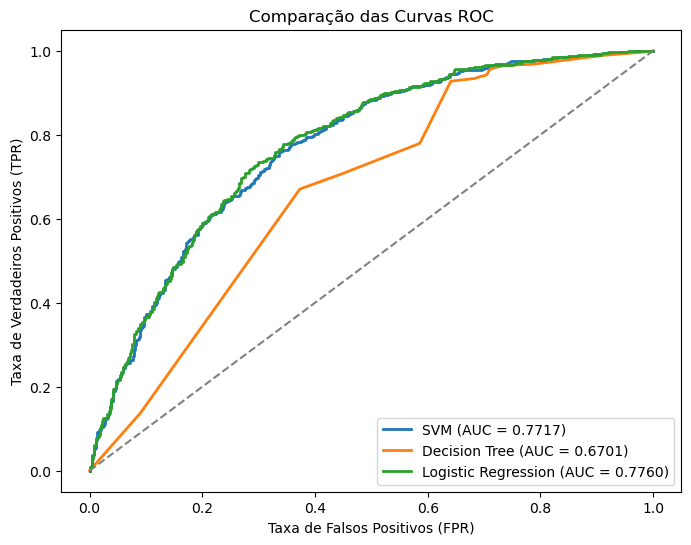

In [509]:
#comparação dos modelos com a base de vinhos tintos
compare_roc_curves(
    models=[search_svm, search_dt_categ, search_reglog],  # GridSearchCV dos modelos
    model_names=['SVM', 'Decision Tree', 'Logistic Regression'],
    x_test=x_red,
    y_test=y_red
)

### INFERINDO OS DADOS DA BASE DE VINHOS TINTOS NO MODELO DE [REGRESSÃO LOGÍSTICA](#)


Best params ==> {'model__C': 1, 'model__class_weight': None, 'model__l1_ratio': 0.25, 'model__penalty': 'elasticnet'}
Best score: 0.7432725992491866
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.90      0.31      0.47       855
           1       0.55      0.96      0.70       744

    accuracy                           0.62      1599
   macro avg       0.73      0.64      0.58      1599
weighted avg       0.74      0.62      0.57      1599


========== Tabela de métricas por iteração do K-Fold ==========
 Fold  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-score Mean  F1-score Std
    1       0.746356      0.000000        0.737116       0.000000     0.746356    0.000000       0.736577      0.000000
    2       0.746356      0.000000        0.736967       0.000149     0.746356    0.000000       0.735625      0.000952
    3       0.742468      0.005497        0.732630       0.006134     0.

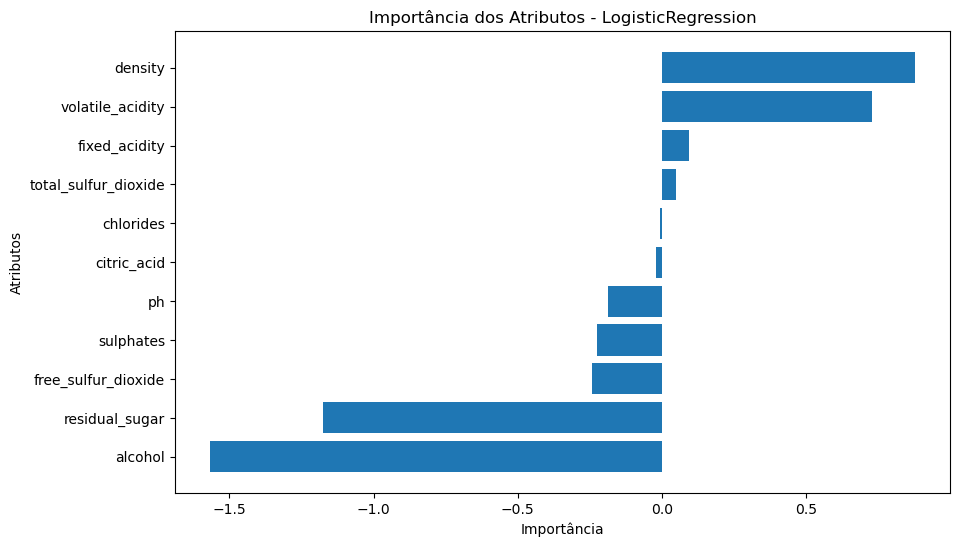

In [511]:
show_results_models(search_reglog, 0, x_red, 0, y_red, False)

### INFERINDO OS DADOS DA BASE DE VINHOS TINTOS NO MODELO DE [ÁRVORE DE DECISÃO](#)


Best params ==> {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_split': 2}
Best score: 0.7301972265796143
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.85      0.31      0.45       855
           1       0.54      0.94      0.69       744

    accuracy                           0.60      1599
   macro avg       0.70      0.62      0.57      1599
weighted avg       0.71      0.60      0.56      1599


========== Tabela de métricas por iteração do K-Fold ==========
 Fold  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-score Mean  F1-score Std
    1       0.725948      0.000000        0.713709       0.000000     0.725948    0.000000       0.712787      0.000000
    2       0.734694      0.008746        0.725399       0.011690     0.734694    0.008746       0.725867      0.013080
    3       0.719145      0.023120        0.708858       0.025

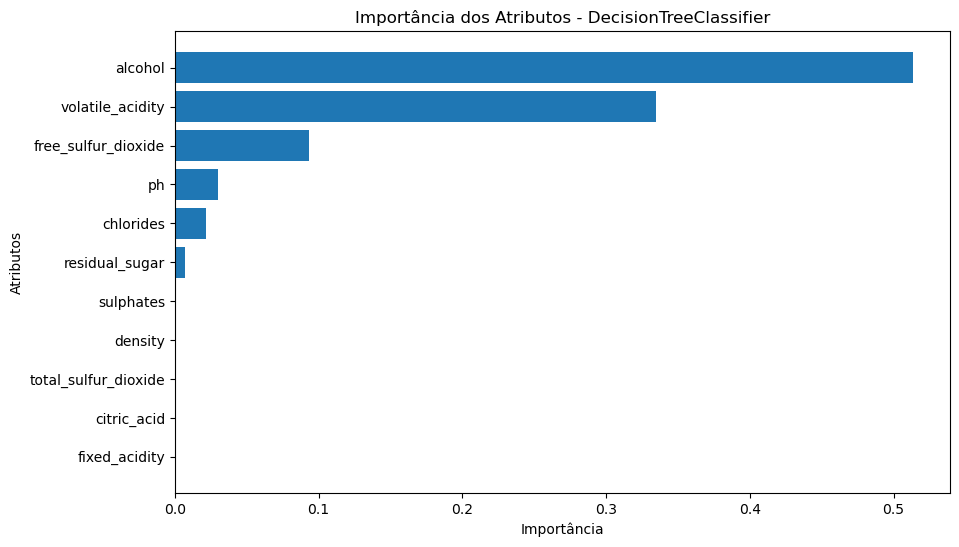

In [515]:
show_results_models(search_dt_categ, 0, x_red, 0, y_red, False)

### INFERINDO OS DADOS DA BASE DE VINHOS TINTOS NO MODELO DE [SVC](#)


Best params ==> {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best score: 0.7415160971210203
Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.91      0.24      0.38       855
           1       0.53      0.97      0.68       744

    accuracy                           0.58      1599
   macro avg       0.72      0.61      0.53      1599
weighted avg       0.73      0.58      0.52      1599


========== Tabela de métricas por iteração do K-Fold ==========
 Fold  Accuracy Mean  Accuracy Std  Precision Mean  Precision Std  Recall Mean  Recall Std  F1-score Mean  F1-score Std
    1       0.737609      0.000000        0.726901       0.000000     0.737609    0.000000       0.725009      0.000000
    2       0.746356      0.008746        0.737387       0.010486     0.746356    0.008746       0.732104      0.007095
    3       0.747328      0.007272        0.738309       0.008661     0.747328    0.007272       0.733477 

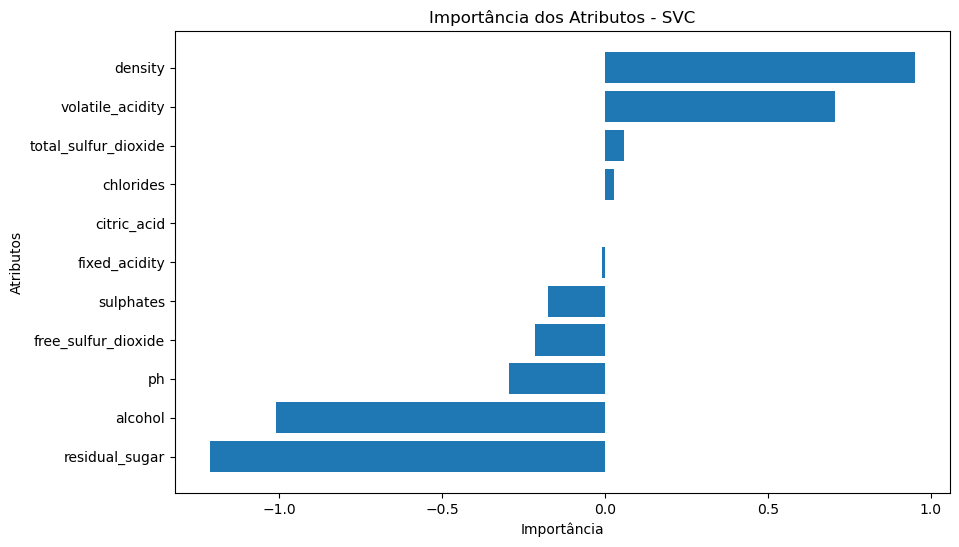

In [517]:
show_results_models(search_svm, 0, x_red, 0, y_red, False)

## Análise Comparativa de Modelos para Classificação de Vinhos  

Este projeto tem como objetivo **avaliar diferentes modelos de aprendizado de máquina** na classificação da qualidade do vinho com base em suas características físico-químicas. Foram testados três algoritmos supervisionados: **Regressão Logística, Support Vector Machine (SVM) e Decision Tree**, comparando seu desempenho através de métricas estatísticas e sua capacidade de generalização.  

### O Problema  

A classificação da qualidade do vinho é um desafio relevante para a indústria vinícola, pois influencia diretamente em fatores como **precificação, aceitação no mercado e padrões de qualidade**. A proposta deste estudo é desenvolver um modelo que possa **classificar vinhos com alta precisão**, minimizando erros que poderiam resultar em prejuízos comerciais, como:  

- **Falsos negativos**: Quando um vinho de alta qualidade é classificado erroneamente como inferior, reduzindo seu valor de mercado.  
- **Falsos positivos**: Quando um vinho de qualidade inferior é classificado como superior, levando a uma precificação inadequada e possível insatisfação do consumidor.  

### O que está sendo avaliado?  

A avaliação dos modelos foi realizada com base nas seguintes métricas:  

- **AUC-ROC** (Área sob a curva ROC): Mede a capacidade do modelo de distinguir entre classes positivas e negativas.  
- **Acurácia**: Proporção de classificações corretas em relação ao total de amostras.  
- **Precisão, Recall e F1-score**: Indicadores que avaliam o equilíbrio entre previsões corretas e erros, especialmente em um cenário onde erros possuem pesos diferentes.  
- **Análise da importância das features**: Para entender quais variáveis têm maior impacto na decisão dos modelos.  

### Principais Resultados  

Os modelos foram treinados **apenas com vinhos brancos** e posteriormente testados com vinhos tintos, o que revelou a seguinte performance:  

- **Regressão Logística** → AUC = 0,77  
- **SVM** → AUC = 0,77  
- **Decision Tree** → AUC = 0,67  

A **Decision Tree apresentou um alto grau de overfitting**, performando bem nos dados de treino, mas falhando ao generalizar para os vinhos tintos. Já a **Regressão Logística e o SVM se mostraram mais robustos**, mantendo um desempenho mais consistente.  

Diante disso, a **Decision Tree foi descartada como uma opção viável**, e a **Regressão Logística foi escolhida como o melhor modelo para futuras otimizações**, pois apresentou uma performance equilibrada entre treino, teste e inferência e um custo computacional muito inferior ao do SVM.  

### Próximos Passos  

Para aprimorar o modelo, seriam necessárias abordagens como:  

- **Inclusão de vinhos tintos no conjunto de treinamento** para evitar viés na inferência.  
- **Ajuste de hiperparâmetros** para maximizar a performance dos modelos mais promissores.  


# Link para acessar o repositório do projeto  

### [GitHub - Estudo Vinhos](https://github.com/BrunoBersan/EstudoVinhos)  
https://github.com/BrunoBersan/EstudoVinhos

# CERTIFICADO DE CONCLUSÃO - CURSO KAGGLE


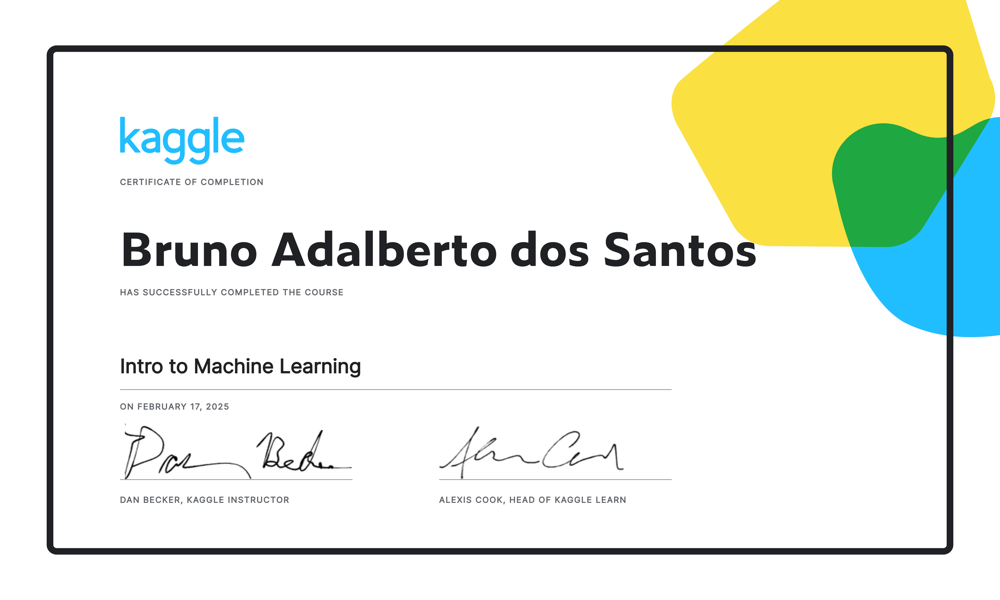

In [17]:
from PIL import Image
from IPython.display import display, HTML 
 
# Carregar a imagem
caminho = "C:/Users/Bruno Adalberto/Desktop/Compartilhada/Certificados/Kaggle - Bruno Adalberto dos Santos - Intro to Machine Learning.png"
imagem = Image.open(caminho)
 
nova_imagem = imagem.resize((1000, 600))

# Exibir a imagem redimensionada
display(nova_imagem)

<h4>Apenas para formatação do HTML final</h4>

In [13]:
# Expand DataFrame display in HTML
display(HTML("""
<style>
.dataframe {
    width: 100% !important;
    table-layout: fixed;
    border-collapse: collapse;
    font-size: 10px;
}
.dataframe th, .dataframe td {
    white-space: nowrap;
    padding: 1px;
    text-align: center;
}
th {
    word-wrap: break-word !important;
    white-space: normal !important;
}

@media print {
    body, table { width: 100% !important; }
    .cell, .output_area, h1, h2, h3, h4 { page-break-inside: avoid !important; }
    img { max-width: 100%; }
}
</style>
"""))
